# Reconocimiento avanzado

Los métodos vistos anteriormente permiten reconocer algunos elementos característicos de las imágenes tales como vértices o círculos. Esto nos permite caracterizar estas imágenes pero no tenemos suficiente información para comparar dos imágenes ya que, aunque se trate de la misma imagen puede estar afectada por escalados o rotaciones que complican la comparación.

El reconocimiento avanzado de imágenes consta de tres elementos:
* Detección de **puntos clave** de las imágenes, que son características destacadas encontradas.
* Cálculo de **descriptores**, que son las relaciones que existen entre los puntos clave de la imagen.
* Comparación de los descriptores de dos imágenes mediante algoritmos de **matching**.

El proceso de comparación de 2 imágenes para comprobar si coinciden (o si una de ellas se encuentra dentro de la otra) consta de 3 pasos:
1. Detección de los puntos clave de las dos imágenes
2. Cáculo de los descriptores de los puntos clave encontrados
3. Comparación de los descriptores para buscar coincidencias

OpenCV implementa algunos métodos de detección de puntos clave, como por ejemplo *FAST*, algunos métodos de cálculo de descriptores, como por ejemplo *BRIEF*, métodos que detectan puntos clave y calculan los descriptores, como por ejemplo *SIFT*, *SURF* y *ORB*, y algoritmos de *matching* como *BF* y *FLANN*

El empleo de estos métodos pasa por la creación de una instancia del mismo para posteriormente hacer llamadas a métodos comunes:
* [**detect**(imagen)](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#aa4e9a7082ec61ebc108806704fbd7887) para la detección de puntos clave en la imagen
* [**compute**(imagen, kp)](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#ab3cce8d56f4fc5e1d530b5931e1e8dc0) para el cálculo de descriptores a partir de la imagen y los puntos clave obtenidos previamente.
* [**detectAndCompute**(imagen)](https://docs.opencv.org/4.x/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677) para el cálculo de puntos clave y descriptores con el mismo método (para los métodos que implementan ambas funcionalidades)

**NOTA:** El algoritmo SURF está patentado y tiene vigentes limitaciones de uso que imposibilitan que sea distribuido en forma binaria en OpenCV. Para poder usarlo es necesario compilar OpenCV indicando la directiva de cmake *-DOPENCV_ENABLE_NONFREE=ON*

In [1]:
import cv2
import numpy as np
import cuia
import camara
baboon = cv2.imread("media/baboon.jpg")

In [2]:
fast = cv2.FastFeatureDetector.create()   # Creación de una instancia del método SIFT
kpfast = fast.detect(baboon)   # Llamada a la función de detección de puntos clave

Con fines de depurado podemos emplear la función [**drawKeypoints**](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920) para mostrar los puntos clave encontrados.

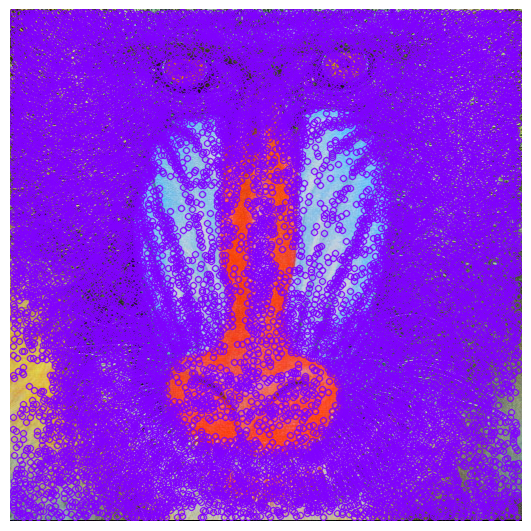

In [3]:
res = baboon.copy()
cv2.drawKeypoints(baboon, kpfast, res, color=(255,0,128))
cuia.plot(res)

El empleo de otro método obtendrá puntos clave diferentes pero la sintaxis será muy similar.

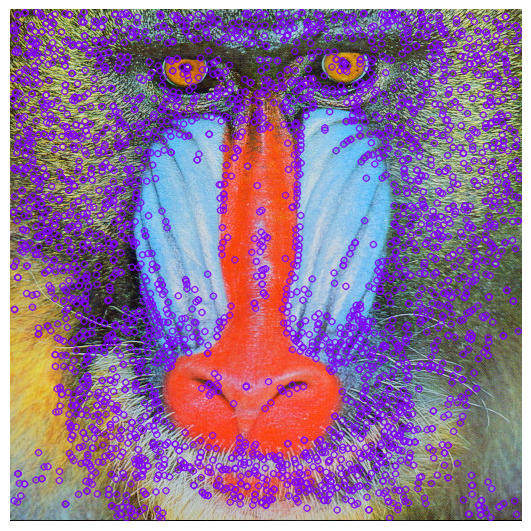

In [4]:
sift = cv2.SIFT.create()
kpsift = sift.detect(baboon)
res = baboon.copy()
cv2.drawKeypoints(baboon, kpsift, res, color=(255,0,128))
cuia.plot(res)

A partir de un conjunto de puntos clave necesitamos calcular los descriptores.

In [5]:
kpsift, descsift = sift.compute(baboon, kpsift)

La combinación de puntos clave y descriptores permitirá reconocer la imagen. Vamos a crear una copia ligeramente alterada que usaremos para tratar de reconocer la imagen original.

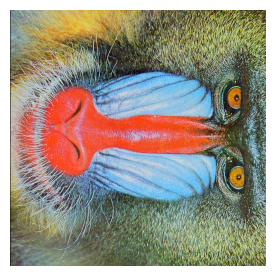

In [6]:
copia = cv2.rotate(baboon, cv2.ROTATE_90_CLOCKWISE)
copia = cv2.resize(copia, dsize=None, fx=0.5, fy=0.5)
cuia.plot(copia)

Usaremos SIFT en esta nueva imagen para posteriormente hacer la comparación. En este caso calcularemos puntos clave y descriptores a la vez.

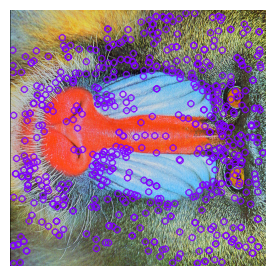

In [7]:
kpsift2, descsift2 = sift.detectAndCompute(copia, mask=None)
res = copia.copy()
cv2.drawKeypoints(copia, kpsift2, res, color=(255,0,128))
cuia.plot(res)

Por último solo falta comparar los puntos clave y descriptores de ambas imágenes. Para esta comparación podemos usar el método de fuerza bruta con la función [knnMatch](https://docs.opencv.org/4.x/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89). El resultado devuelto es una lista de parejas de descriptores coincidentes juto con información relevante a dicha coincidencia tal como la distancia. Un filtro sugerido por los autores es conservar las coincidencias en las que la distancia de una es inferior al 70% de la otra.

Con fines de depurado podemos emplear la función [drawMatches](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gaf92cd1c6e9400e4753ce393d2fdc06b0) para mostrar las imágenes y las coincidencias encontradas.

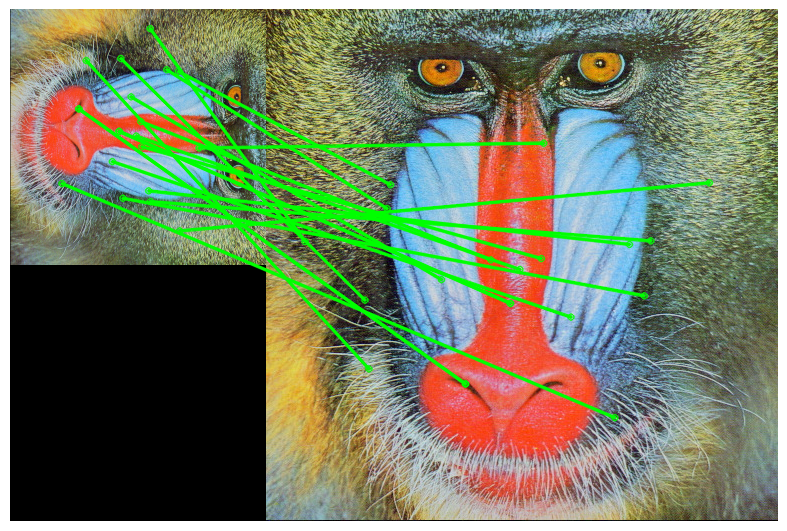

In [8]:
bf = cv2.BFMatcher.create()  # Creamos una instancia del método de fuerza bruta
coincidencias = bf.knnMatch(descsift2, descsift, k=2) # Encontramos las coincidencias entre los descriptores de ambas imágenes
good = []
for m, n in coincidencias:
    if m.distance < 0.7*n.distance:
        good.append(m)

good = sorted(good, key=lambda x: x.distance) # Ordenamos las coincidencias por distancia para quedarnos con las mejores

res = cv2.drawMatches(copia, kpsift2, baboon, kpsift, good[:20], res, matchesThickness=2, matchColor=(0,255,0), singlePointColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cuia.plot(res)

A partir del conjunto de coincidencias podemos obtener el conjunto de puntos de una imagen y su ubicación en la otra.

Cada coincidencia contiene, entre otros, atributos que indican...:
* distance (distancia relativa entre los descrptores)
* queryIdx (índice en el vector de descriptores de la primera imagen)
* trainIdx (índice en el vector de descriptores de la segunda imagen)

Cada punto clave tiene, entre otros, un atributo **pt** que indica las coordenadas del punto.

Con esta información podemos calcular la homografía que transforma la imagen original en la imagen obtenida mediante [solvePnP](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga549c2075fac14829ff4a58bc931c033d) de un modo similar al visto anteriormente para implementar Realidad Aumentada. En efecto esto nos permitirá realizar realidad aumentada usando patrones genéricos.

In [9]:
opencv = cv2.imread("media/opencv.png", cv2.IMREAD_UNCHANGED)
fondo = np.full_like(opencv[:,:,0:3], 255)
imagen = cuia.alphaBlending(opencv, fondo)
kp, desc = sift.detectAndCompute(imagen, None)
ancho = 0.150 # ancho en m de la impresión de opencv
_, w, _ = opencv.shape
ratio = ancho/w # metros/px
puntosopencv = tuple([tuple([ratio*t for t in kp[i].pt + (0,)]) for i in range(len(kp))])
def buscaOpenCV(frame):
    kp2, desc2 = sift.detectAndCompute(frame, None)
    coincidencias = bf.knnMatch(desc2, desc, k=2)
    good = []
    for m, n in coincidencias:
        if m.distance < 0.7*n.distance:
            good.append(m)
    good = sorted(good, key=lambda x: x.distance)

    origen=[]
    destino=[]
    if len(good[:10])>4:
        for c in good:
            origen.append(puntosopencv[c.trainIdx])
            destino.append(kp2[c.queryIdx].pt)
        ret, rvec, tvec = cv2.solvePnP(np.array(origen), np.array(destino), camara.cameraMatrix, camara.distCoeffs)
        frame = cv2.drawFrameAxes(frame, camara.cameraMatrix, camara.distCoeffs, rvec, tvec, length=0.10, thickness=2)
    return(frame)

In [ ]:
camId = 0
bk = cuia.bestBackend(camId)

In [11]:
webcam = cuia.myVideo(camId, bk)
webcam.process = buscaOpenCV
webcam.play("WEBCAM")
webcam.release()